# Clairvoyante


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import numpy as np
import time
import pickle
from random import randrange

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import clairvoyante.utils as utils
import clairvoyante.clairvoyante as cv
import clairvoyante.param as param

Please run prepDataBeforeDemo.sh to generate training and testing data from BAM and VCF files before proceeding.

References:
1. The GIAB v3.3.2 NA12878 truth variant dataset is available at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/NA12878_HG001/NISTv3.3.2/GRCh38
2. The Illumina alignment is available at ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/NA12878/NIST_NA12878_HG001_HiSeq_300x/, the chr21.bam and chr22.bam were extracted from the HG001.GRCh38_full_plus_hs38d1_analysis_set_minus_alts.300x.bam file, downsampled to 50x.

#### prepDataBeforeDemo.sh:
```
mkdir ../training
python ../dataPrepScripts/ExtractVariantCandidates.py --bam_fn ../testingData/chr21/chr21.bam --ref_fn ../testingData/chr21/chr21.fa --can_fn ../training/can_chr21 --ctgName chr21 --ctgStart 10269870 --ctgEnd 46672937 &
python ../dataPrepScripts/GetTruth.py --vcf_fn ../testingData/chr21/chr21.vcf --var_fn ../training/var_chr21 --ctgName chr21 &
python ../dataPrepScripts/ExtractVariantCandidates.py --bam_fn ../testingData/chr22/chr22.bam --ref_fn ../testingData/chr22/chr22.fa --can_fn ../training/can_chr22 --ctgName chr22 --ctgStart 18924717 --ctgEnd 49973797 &
python ../dataPrepScripts/GetTruth.py --vcf_fn ../testingData/chr22/chr22.vcf --var_fn ../training/var_chr22 --ctgName chr22 &
wait

python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr21/chr21.bam --can_fn ../training/can_chr21 --ref_fn ../testingData/chr21/chr21.fa --tensor_fn ../training/tensor_can_chr21 --ctgName chr21 --ctgStart 10269870 --ctgEnd 46672937 &
python ../dataPrepScripts/CreateTensor.py --bam_fn ../testingData/chr22/chr22.bam --can_fn ../training/can_chr22 --ref_fn ../testingData/chr22/chr22.fa --tensor_fn ../training/tensor_can_chr22 --ctgName chr22 --ctgStart 18924717 --ctgEnd 49973797 &
wait

cat ../training/can_chr21 ../training/can_chr22 > ../training/can_mul
cat ../training/var_chr21 ../training/var_chr22 > ../training/var_mul
cat ../training/tensor_can_chr21 ../training/tensor_can_chr22 > ../training/tensor_can_mul
cat ../testingData/chr21/chr21.bed ../testingData/chr22/chr22.bed > ../training/bed
python tensor2Bin.py --tensor_fn ../training/tensor_can_mul --var_fn ../training/var_mul --bed_fn ../training/bed --bin_fn ../training/tensor.bin
```

## Train using the chr21+chr22 variants

In [3]:
# Load the preprocessed and compressed tensors into memory
with open("../training/tensor.bin", "rb") as fh:
    total = pickle.load(fh)
    XArrayCompressed = pickle.load(fh)
    YArrayCompressed = pickle.load(fh)
    posArrayCompressed = pickle.load(fh)

In [4]:
print >> sys.stderr, "The size of training dataset: {}".format(total)

The size of training dataset: 132765


In [5]:
# Pick a random candidate
i = randrange(total)
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

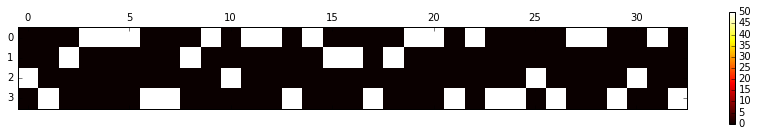

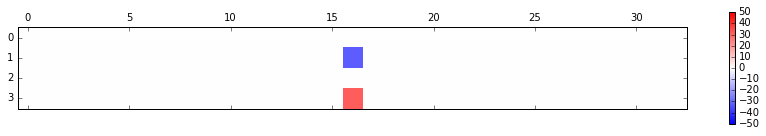

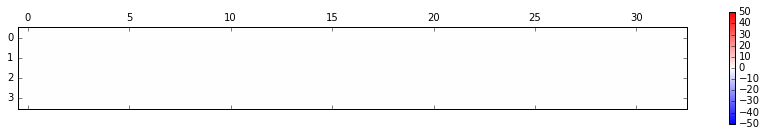

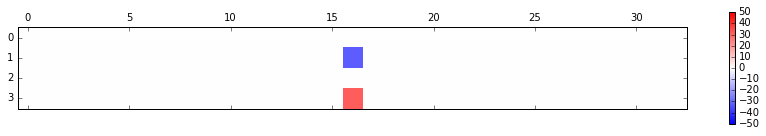

In [6]:
# Show how the four matrices are like
figure(figsize=(15, 2)); matshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, cmap=cm.hot, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()
figure(figsize=(15, 2)); matshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, cmap=cm.bwr, fignum=0); colorbar()

In [7]:
# create a Clairvoyante network
m = cv.Clairvoyante()
m.init()

In [8]:
# training the model. The code train on all variants and validate on the first 10% variant sites
trainingStart = time.time()
trainBatchSize = param.trainBatchSize
validationLosts = []
numValItems = int(len(XArray) * 0.1 + 0.499)
print >> sys.stderr, "Start at learning rate: %.2e" % m.setLearningRate(0.001)
c = 0; maxLearningRateSwitch = 3
epochStart = time.time()
datasetPtr = 0
numValItems = int(total * 0.1 + 0.499)
valXArray, _, _ = utils.DecompressArray(XArrayCompressed, 0, numValItems, total)
valYArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, numValItems, total)
print >> sys.stderr, "Number of variants for validation: %d" % len(valXArray)
i = 1
while i < (1 + int(param.maxEpoch * total / trainBatchSize + 0.499)):
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, trainBatchSize, total)
    YBatch, _, _ = utils.DecompressArray(YArrayCompressed, datasetPtr, trainBatchSize, total)
    loss, _ = m.train(XBatch, YBatch)
    if endFlag != 0:
        validationLost = m.getLoss( valXArray, valYArray )
        print >> sys.stderr, " ".join([str(i),\
                                       "Training lost:", str(loss/trainBatchSize),\
                                       "Validation lost: ", str(validationLost/numValItems),\
                                       "Epoch time elapsed: %.2f s" % (time.time() - epochStart)])
        validationLosts.append( (validationLost, i) )
        c += 1
        flag = 0
        if c >= 4:
            if validationLosts[-4][0] - validationLosts[-3][0] > 0:
                if validationLosts[-3][0] - validationLosts[-2][0] < 0:
                    if validationLosts[-2][0] - validationLosts[-1][0] > 0:
                        flag = 1
            elif validationLosts[-4][0] - validationLosts[-3][0] < 0:
                if validationLosts[-3][0] - validationLosts[-2][0] > 0:
                    if validationLosts[-2][0] - validationLosts[-1][0] < 0:
                        flag = 1
            else: flag = 1
        if flag == 1:
            maxLearningRateSwitch -= 1
            if maxLearningRateSwitch == 0: break
            print >> sys.stderr, "New learning rate: %.2e" % m.setLearningRate()
            c = 0
        epochStart = time.time()
        datasetPtr = 0
    i += 1
    datasetPtr += trainBatchSize

print >> sys.stderr, "Training time elapsed: %.2f s" % (time.time() - trainingStart)

Start at learning rate: 1.00e-03
Number of variants for validation: 13276
27 Training lost: 0.468646679688 Validation lost:  0.76480761807 Epoch time elapsed: 78.58 s
53 Training lost: 0.323882617187 Validation lost:  0.5434867121 Epoch time elapsed: 90.91 s
79 Training lost: 0.186701477051 Validation lost:  0.302858744015 Epoch time elapsed: 97.61 s
105 Training lost: 0.125648339844 Validation lost:  0.218032988628 Epoch time elapsed: 97.31 s
131 Training lost: 0.104345605469 Validation lost:  0.168846707345 Epoch time elapsed: 89.72 s
157 Training lost: 0.08053671875 Validation lost:  0.128230716421 Epoch time elapsed: 87.83 s
183 Training lost: 0.0592120239258 Validation lost:  0.0896385953742 Epoch time elapsed: 87.79 s
209 Training lost: 0.0547924316406 Validation lost:  0.0742770359077 Epoch time elapsed: 89.04 s
235 Training lost: 0.0418676757813 Validation lost:  0.0701548135866 Epoch time elapsed: 98.72 s
261 Training lost: 0.0382120849609 Validation lost:  0.0558404695488 Epo

## Testing on the training dataset

In [9]:
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases, ts = m.predict(XBatch)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, t = m.predict(XBatch)
    bases = np.append(bases, base, 0)
    ts = np.append(ts, t, 0)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
print >> sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart)


YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print >> sys.stderr, "Model evaluation on the training dataset:"
ed = np.zeros( (5,5), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,4:]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1

for i in range(5):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(5)])

Prediciton time elapsed: 27.21 s
Model evaluation on the training dataset:
50431	2	1	0	97
10	27664	1	0	0
14	4	129	0	3
2	0	5	30	9
83	3	15	6	54256


## Testing on the chr22 variants

In [10]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("../training/tensor_can_chr22",
                       "../training/var_chr22",
                       "../training/bed")
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

In [ ]:
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases, ts = m.predict(XBatch)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, t = m.predict(XBatch)
    bases = np.append(bases, base, 0)
    ts = np.append(ts, t, 0)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
print >> sys.stderr, "Time elapsed: %.2f s" % (time.time() - predictStart)

print >> sys.stderr, "Model evaluation on the chr22 variants:"
ed = np.zeros( (5,5), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,4:]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1

for i in range(5):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(5)])

## Visualizing predictions

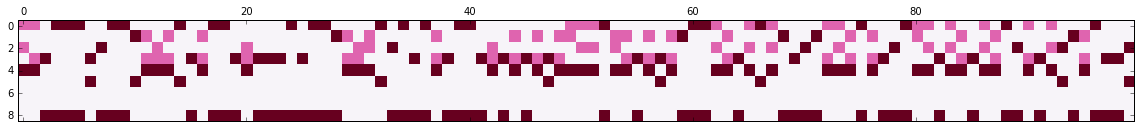

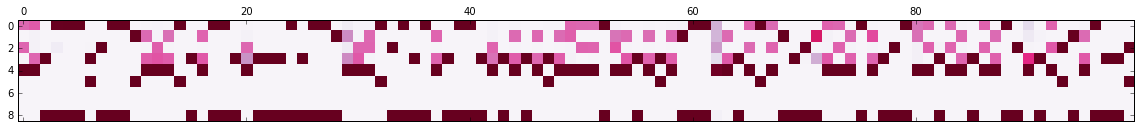

In [12]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],ts[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)